In [127]:
# library(tidyverse)
# library(stats)
# library(readxl)
# library(forecast)
library(quantmod)
library(ggplot2)
library(tseries)
library(gridExtra)
library(forecast)
library(lmtest)

In [31]:
HomePrice = read.csv("./US_National_Home_price.csv")

HomePrice = xts(HomePrice, order.by=as.Date(HomePrice$DATE, format="%Y-%m-%d")) 
storage.mode(HomePrice) = "numeric"
HomePrice$DATE = NULL

Warning message in storage.mode(HomePrice) = "numeric":
“NAs introduced by coercion”

In [32]:
head(HomePrice)

           CSUSHPINSA
1987-01-01     63.753
1987-02-01     64.153
1987-03-01     64.490
1987-04-01     64.995
1987-05-01     65.570
1987-06-01     66.238

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.


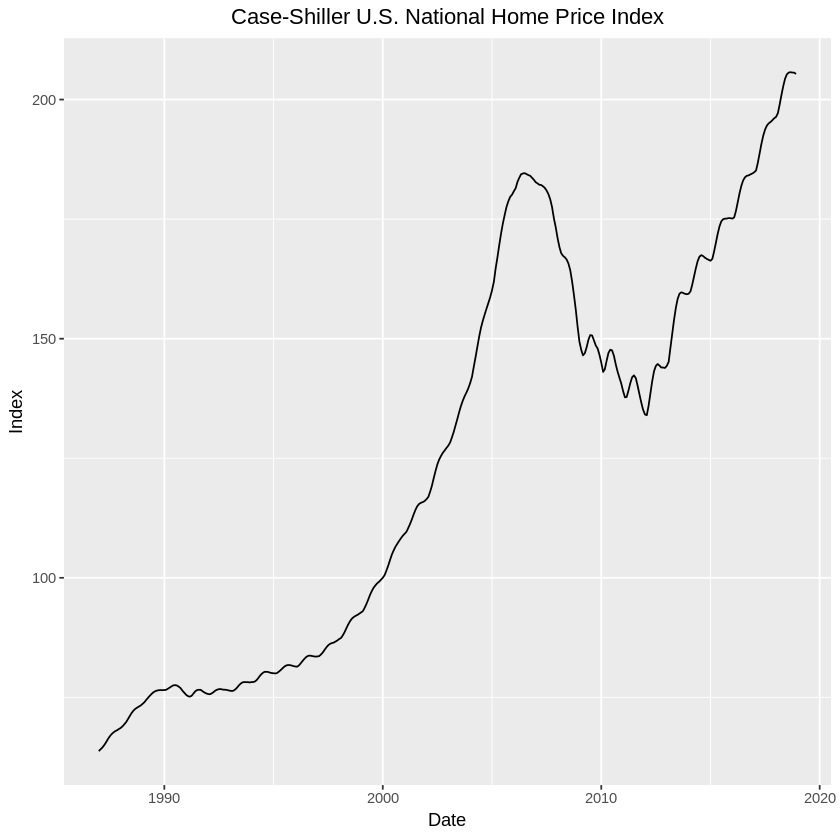

In [33]:
ggplot(HomePrice, aes(Index)) + 
    geom_line(aes(y = HomePrice$CSUSHPINSA))+
    ggtitle("Case-Shiller U.S. National Home Price Index") +
    labs(x = "Date", y = "Index") + 
    theme(plot.title = element_text(hjust = 0.5))

In [34]:
# Perform adf test with time series of HomePrice
# See https://stackoverflow.com/questions/16447461/adf-test-returning-p-0-99-with-xts-but-returning-p-0-01-with-coredataxts
# Null Hypothesis - Unit root is present
# Alternative Hypothesis - Stationary

# At 1% significance level, we cannot reject the null hypothesis that an unit root is present.
# The series is likely to have an unit root and is not stationary

adf.test(as.ts(HomePrice))


	Augmented Dickey-Fuller Test

data:  as.ts(HomePrice)
Dickey-Fuller = -2.3903, Lag order = 7, p-value = 0.4123
alternative hypothesis: stationary


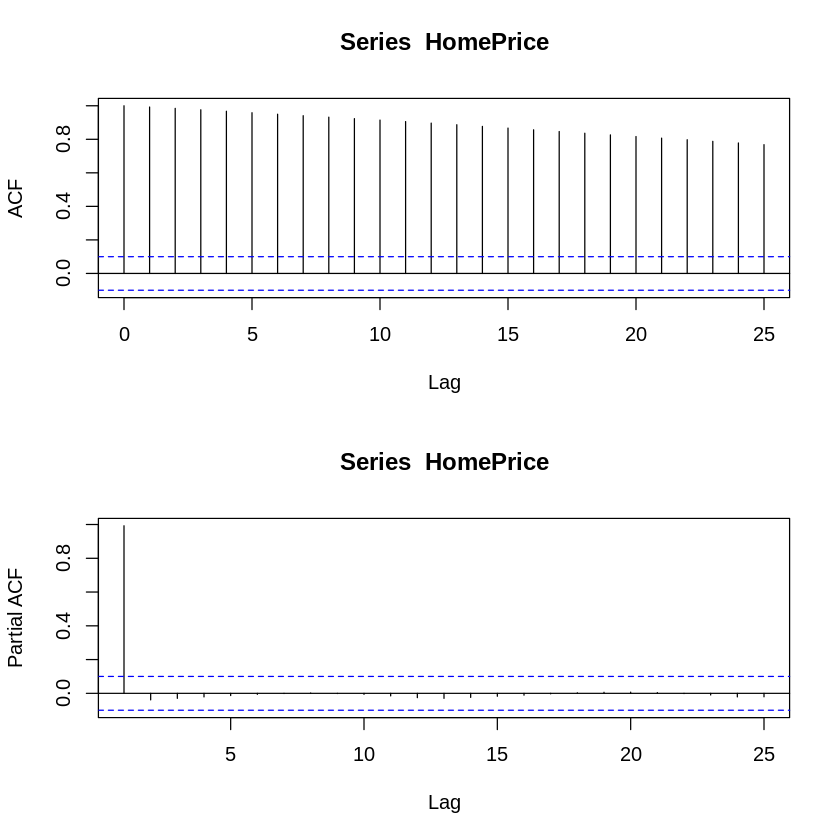

In [35]:
# Plot ACF & PACF for HomePrice
par(mfrow=c(2,1))
acf(HomePrice)
pacf(HomePrice)

In [40]:
# Applying diff1
differenced = diff(HomePrice, differences = 1)
differenced = differenced[2:nrow(differenced)]
adf.test(as.ts(differenced))


	Augmented Dickey-Fuller Test

data:  as.ts(differenced)
Dickey-Fuller = -2.7611, Lag order = 7, p-value = 0.2558
alternative hypothesis: stationary


In [52]:
# Applying diff2
differenced = diff(HomePrice, differences = 2)
differenced = differenced[3:nrow(differenced)]
adf.test(as.ts(differenced))

Warning message in adf.test(as.ts(differenced)):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  as.ts(differenced)
Dickey-Fuller = -15.602, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


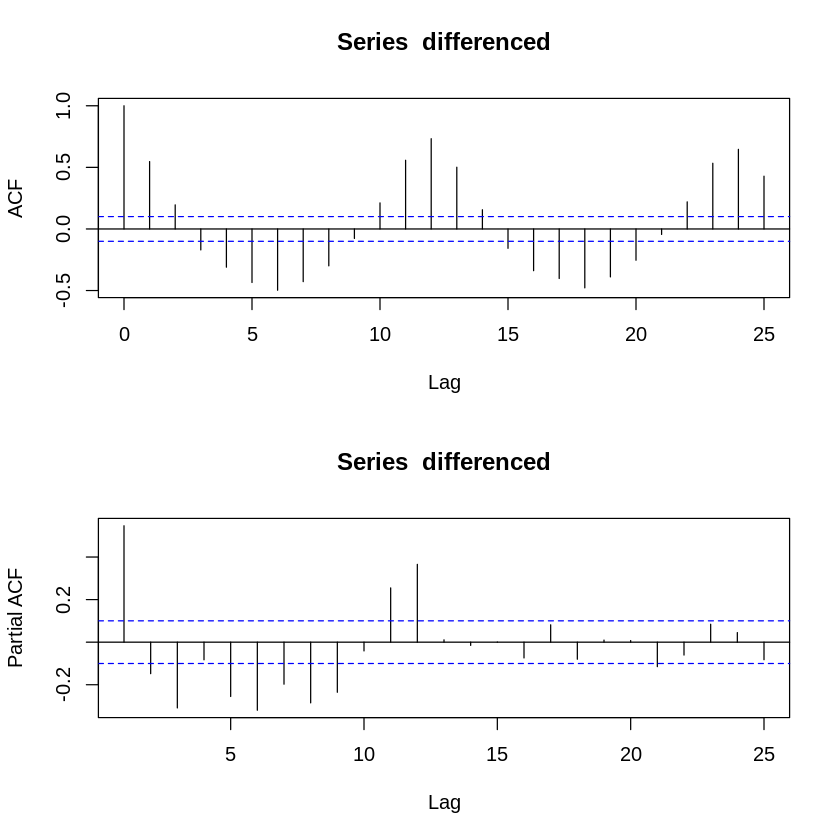

In [53]:
# Plot ACF & PACF for differenced model
par(mfrow=c(2,1))
acf(differenced)
pacf(differenced)

# https://stats.stackexchange.com/questions/49571/understanding-the-blue-dotted-lines-in-an-acf-from-r
# Autocorrelations are significantly different from zero, suggesting seasonality
# A strong negative correlation at lag 6 and strong positive correlation at lag 12
# Sinusiodal ACF may suggest an AR(2)

In [224]:
ARIMA_model <- arima(window(differenced), order=c(0,0,2), method = "ML")
ARIMA_model
summary(ARIMA_model)
Box.test(ARIMA_model$residuals, lag = 2)


Call:
arima(x = window(differenced), order = c(0, 0, 2), method = "ML")

Coefficients:
         ma1     ma2  intercept
      0.6201  0.4157    -0.0027
s.e.  0.0458  0.0465     0.0345

sigma^2 estimated as 0.1101:  log likelihood = -120.86,  aic = 249.73


Call:
arima(x = window(differenced), order = c(0, 0, 2), method = "ML")

Coefficients:
         ma1     ma2  intercept
      0.6201  0.4157    -0.0027
s.e.  0.0458  0.0465     0.0345

sigma^2 estimated as 0.1101:  log likelihood = -120.86,  aic = 249.73

Training set error measures:
                       ME      RMSE       MAE MPE MAPE      MASE        ACF1
Training set 0.0001216227 0.3317681 0.2009387 Inf  Inf 0.8247257 0.001587027



	Box-Pierce test

data:  ARIMA_model$residuals
X-squared = 0.086441, df = 2, p-value = 0.9577


Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.


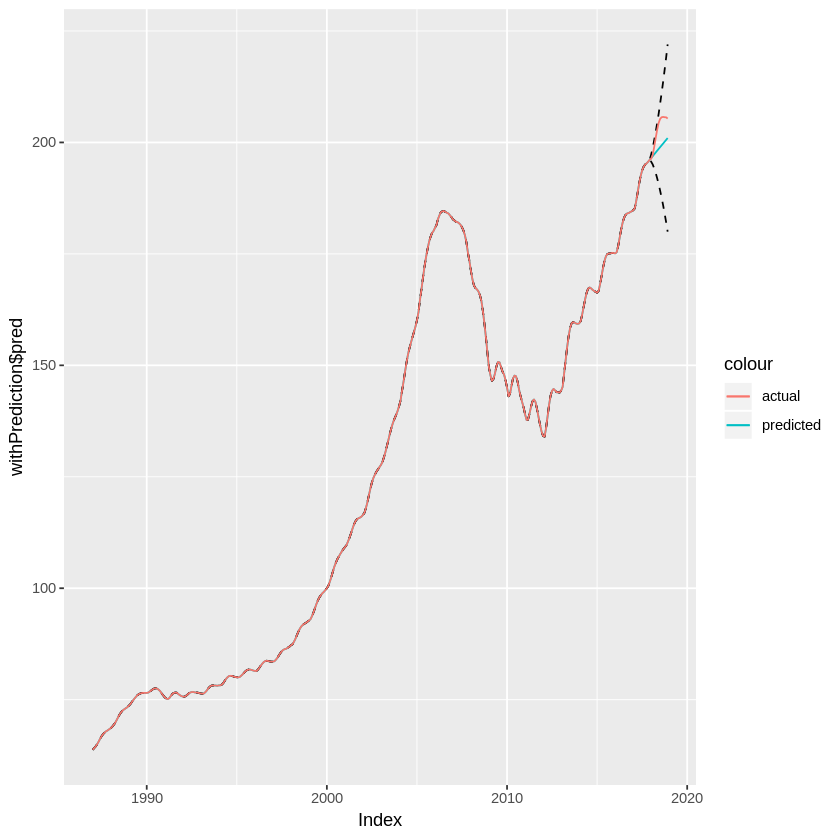

In [116]:
periodToForecast = 12
trainPeriod = nrow(HomePrice)-periodToForecast
train = HomePrice[1:trainPeriod]

fit = arima(train, order=c(0,2,0),  method = "ML")
predictions = predict(fit,n.ahead=periodToForecast,se.fit=TRUE)

# Create vectors with prediction, 2 * SE bounds
pred = c()
upper = c()
lower = c()
for(i in 1:nrow(HomePrice)){
    if(i <= nrow(HomePrice) - periodToForecast){
        pred[i] = HomePrice$CSUSHPINSA[i]
        upper[i] = HomePrice$CSUSHPINSA[i]
        lower[i] = HomePrice$CSUSHPINSA[i]
    }else{
        p = i - trainPeriod
        pred[i] = predictions$pred[p]
        upper[i] = predictions$pred[p] + 2*predictions$se[p]
        lower[i] = predictions$pred[p] - 2*predictions$se[p]
    }
}

withPrediction = merge(HomePrice, pred, upper, lower)

ggplot(withPrediction, aes(Index)) + 
    geom_line(aes(y = withPrediction$pred, color="predicted")) +
    geom_line(aes(y = withPrediction$upper), linetype="dashed") +
    geom_line(aes(y = withPrediction$lower), , linetype="dashed") +
    geom_line(aes(y = withPrediction$CSUSHPINSA, color="actual"))

# acf(fit$residuals)
# pacf(fit$residuals)


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


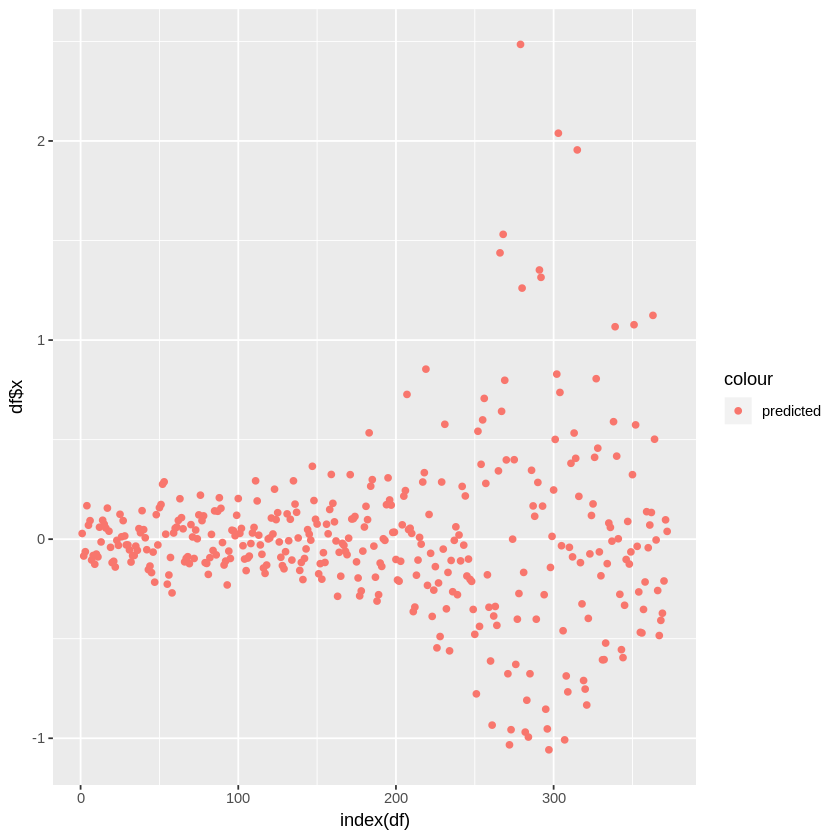

In [117]:
df = as.data.frame(fit$residuals)
ggplot(df, aes(index(df))) + 
    geom_point(aes(y = df$x, color="predicted"))

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


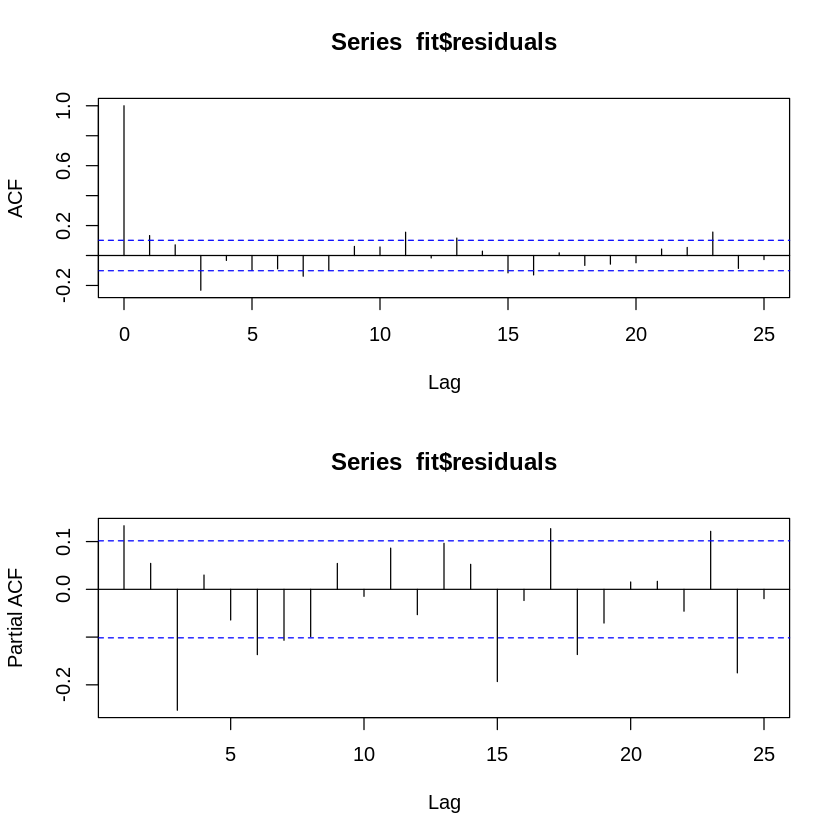

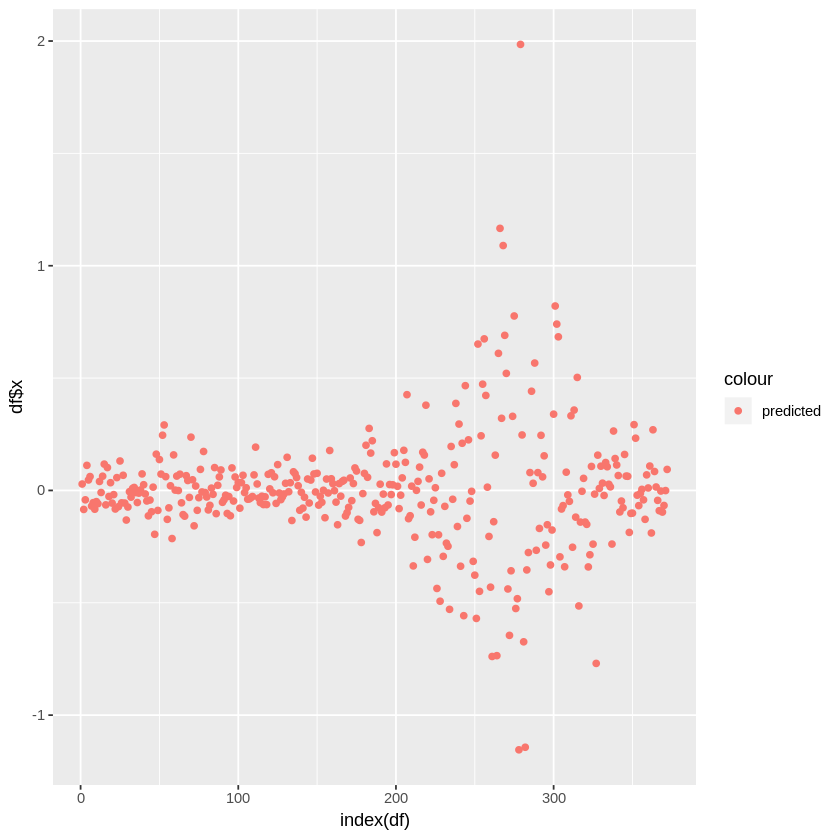

In [235]:
fit = arima(train, order=c(0,2,0), seasonal=list(order=c(2,0,0),period=12),  method = "ML")

# accuracy(fit)
# coeftest(fit)

par(mfrow=c(2,1))
acf(fit$residuals)
pacf(fit$residuals)

df = as.data.frame(fit$residuals)
ggplot(df, aes(index(df))) + 
    geom_point(aes(y = df$x, color="predicted"))

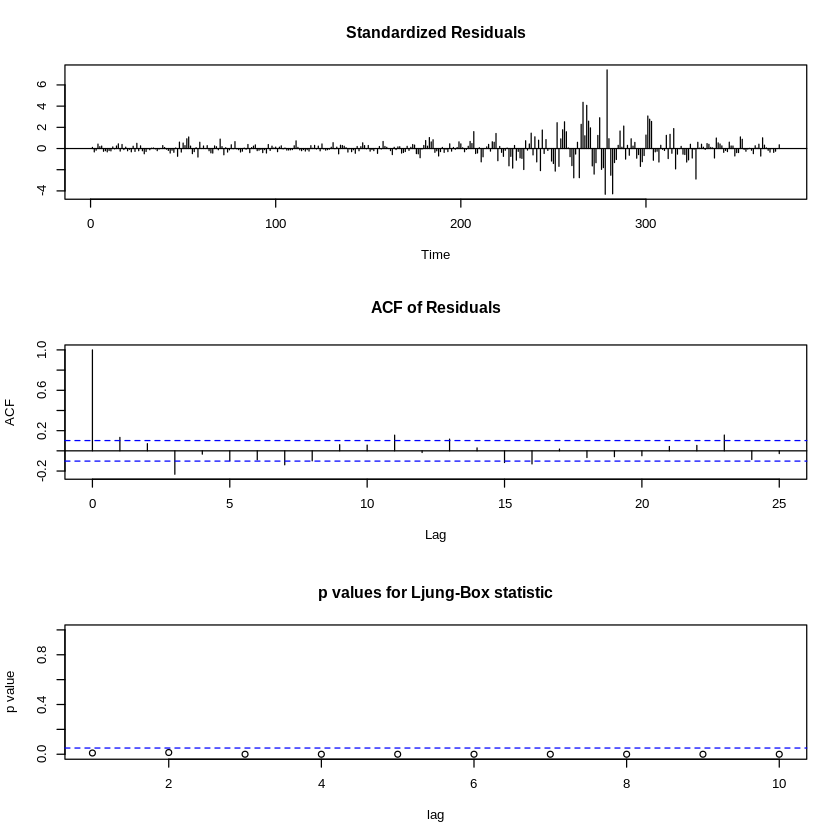

In [236]:
tsdiag(fit)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1
Training set,-8.923999e-05,0.3307095,0.1982458,0.001868618,0.1502042,0.267474,3.615309e-05


Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


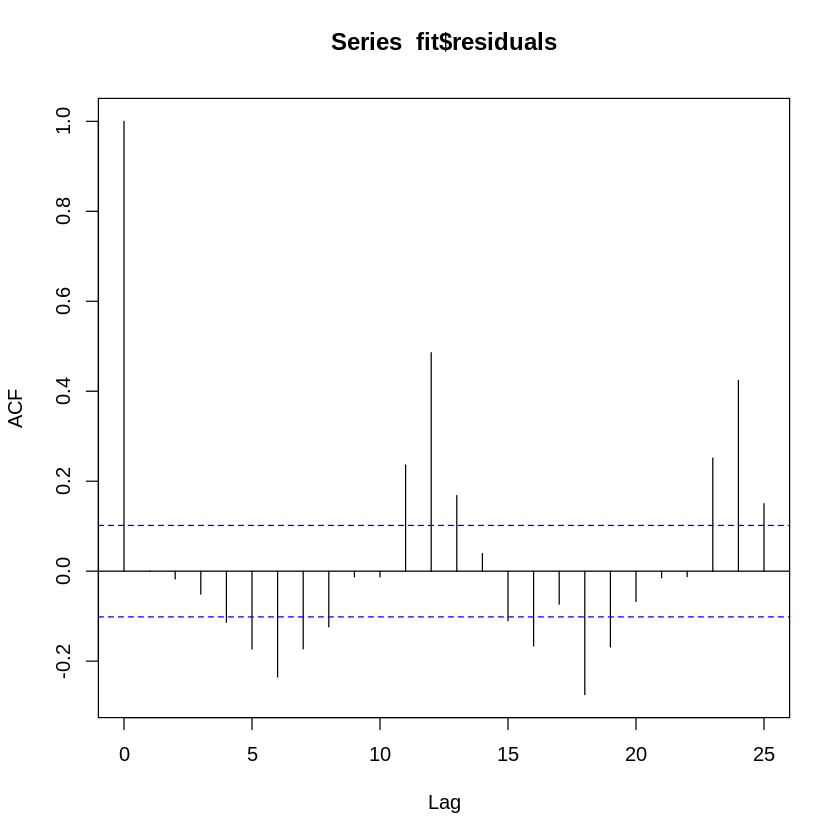


	Box-Pierce test

data:  fit$residuals
X-squared = 4.8622e-07, df = 1, p-value = 0.9994


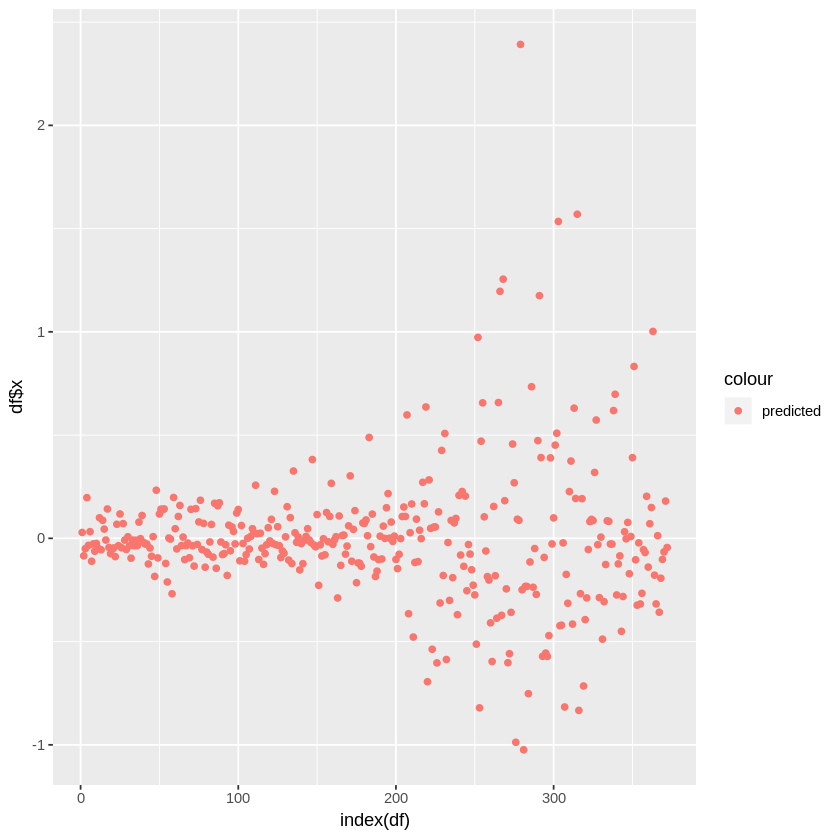

In [226]:
fit = arima(train, order=c(0,2,2), method = "ML")
accuracy(fit)
#coeftest(fit)
acf(fit$residuals)
df = as.data.frame(fit$residuals)
ggplot(df, aes(index(df))) + 
    geom_point(aes(y = df$x, color="predicted"))
Box.test(fit$residuals, lag = 1)

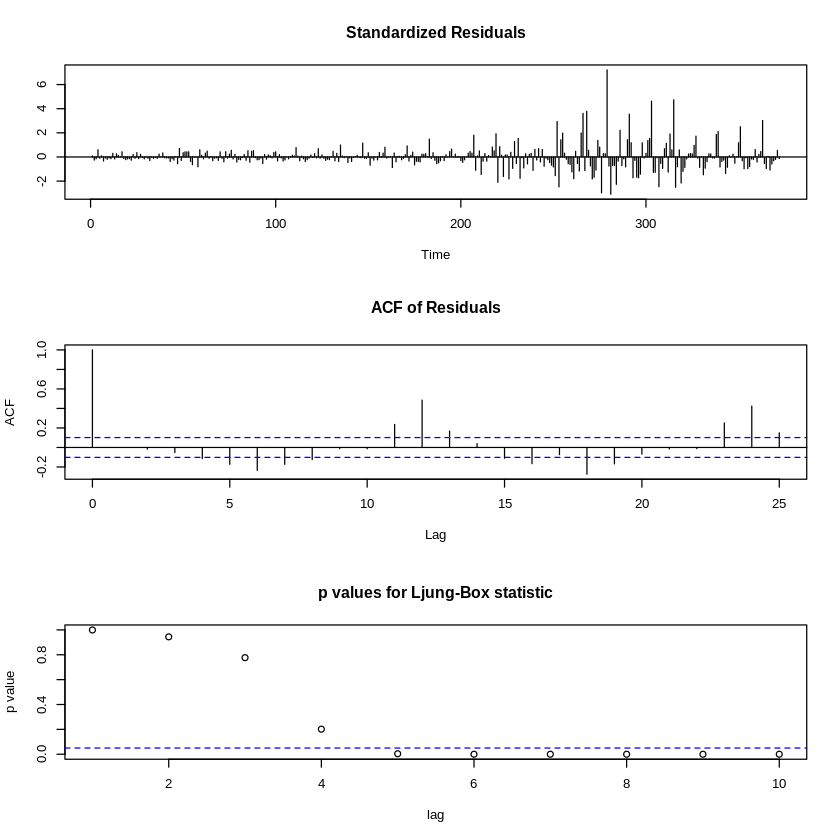

In [227]:
tsdiag(fit)

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.


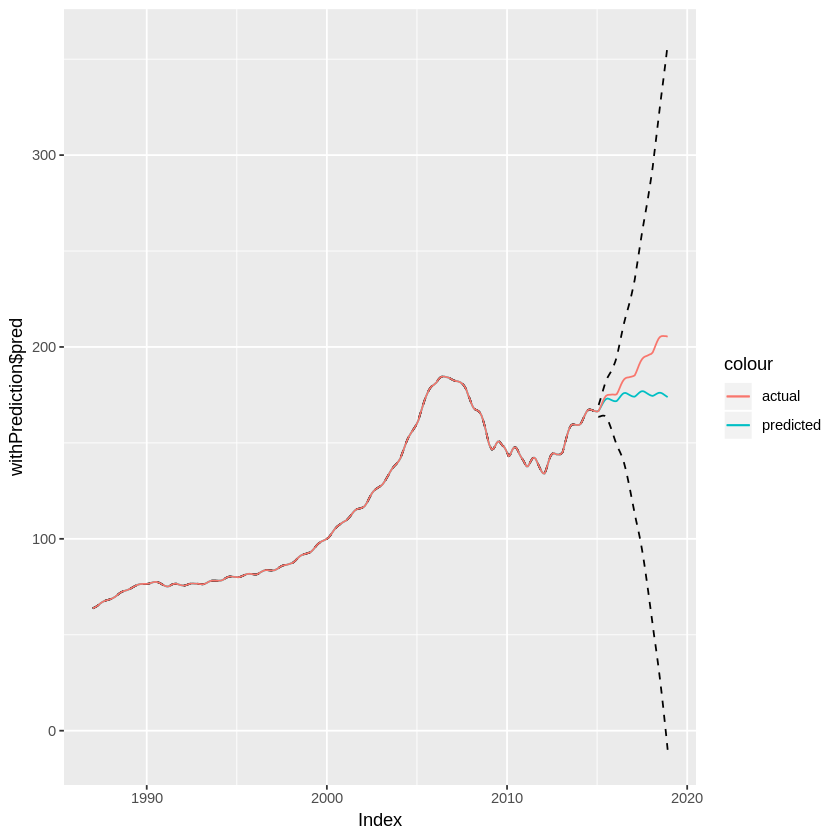

In [238]:
periodToForecast = 50
trainPeriod = nrow(HomePrice)-periodToForecast
train = HomePrice[1:trainPeriod]

fit = arima(train, order=c(0,2,0), seasonal=list(order=c(2,0,0),period=12),  method = "ML")
predictions = predict(fit,n.ahead=periodToForecast,se.fit=TRUE)

# Create vectors with prediction, 2 * SE bounds
pred = c()
upper = c()
lower = c()
for(i in 1:nrow(HomePrice)){
    if(i <= nrow(HomePrice) - periodToForecast){
        pred[i] = HomePrice$CSUSHPINSA[i]
        upper[i] = HomePrice$CSUSHPINSA[i]
        lower[i] = HomePrice$CSUSHPINSA[i]
    }else{
        p = i - trainPeriod
        pred[i] = predictions$pred[p]
        upper[i] = predictions$pred[p] + 2*predictions$se[p]
        lower[i] = predictions$pred[p] - 2*predictions$se[p]
    }
}

withPrediction = merge(HomePrice, pred, upper, lower)

ggplot(withPrediction, aes(Index)) + 
    geom_line(aes(y = withPrediction$pred, color="predicted")) +
    geom_line(aes(y = withPrediction$upper), linetype="dashed") +
    geom_line(aes(y = withPrediction$lower), , linetype="dashed") +
    geom_line(aes(y = withPrediction$CSUSHPINSA, color="actual"))

# acf(fit$residuals)
# pacf(fit$residuals)
